---
description: Here we show how to solve the item listing optimization for E-Commerce using JijZept.
---

# Item Listing Optimization for E-Commerce Websites Based on Diversity

<!-- # 多様性を含めたEコマースサイトのアイテムリスト最適化 -->

<!-- 商品販売・宿泊施設予約・音楽や動画配信サイトのように、課金システムを持つEコマースサイトは、私たちにとって身近なものとなりました。これらのサイトを見ると、様々なアイテムが掲載されています。掲載されるアイテムをどのように決定するか、どのような配置で並べるかは、Eコマースサイトの売り上げに直結する重要な問題です。単純に売上数などの人気順で並べてしまうと、類似性の高いアイテムが連続して配置されることが多く、特定の趣味趣向に偏る可能性があります。そこで[Nishimura et al., 2019](https://doi.org/10.3389/fcomp.2019.00002)では、類似度の高い項目が隣り合って配置されることに対するペナルティなどを用い、項目リスト問題を二次割り当て問題として定式化しました。そしてそれを量子アニーリングで解き、アイテムの人気度と多様性を考慮したアイテムリストを作成するのに成功しました。今回はこの問題を題材にして、JijModelingによる数理モデル実装と、JijZeptでの求解をしてみましょう。 -->

E-commerce sites with billing systems, such as product sales, hotel reservations, and music and video streaming sites, have become familiar with us today.
These sites list a wide variety of items.
One of the most important issue on these websites is how to decide which items to list and how to arrange them. 
That problem directly affects sales on e-commerce sites.
If items are simply ordered by popularity (e.g., number of sales), highly similar items are often placed consecutively, which may lead to a bias toward a specific preference.
Therefore, [Nishimura et al. (2019)](https://doi.org/10.3389/fcomp.2019.00002) formulated the item listing problem as a quadratic assignment problem, using penalties for items with high similarity being placed next to each other.
They then solved the problem with quantum annealing and succeeded in creating an item list that simultaneously accounts for item popularity and diversity.
In this article, we implement the mathematical model using JijModeling, and solve it using JijZept.

<!-- ## 数理モデル -->

## A mathematical model

<!-- ウェブサイトのどの位置にどのアイテムを掲載するかを考えましょう。
掲載されるアイテムの集合を$I$、アイテムが掲載される位置の集合を$J$と定義します。
アイテム$i$を$j$番目の位置に配置するとき$x_{i, j} = 1$、それ以外の場合には$x_{i, j} = 0$となるようなバイナリ変数を用います。 -->

Let us consider which items are listed in which positions on a given website.
We define the set of items to be listed as $I$ and the set of positions where items are listed as $J$.
We use a binary variable $x_{i, j} = 1$ that represents  to assign item $i$ to position $j$, and $x_{i, j} = 0$ otherwise.

<!-- ### 各アイテムはどこか一箇所に掲載されなければならない -->

### Ensure that only one item is allocated to each position

$$
\sum_{j \in J} x_{ij} = 1 \qquad (\forall i) \tag{1}
$$

<!-- ### 一つの場所には一つのアイテムしか掲載できない -->

### Ensure that only one position is allocated to each item

$$
\sum_{i \in I} x_{ij} = 1 \qquad (\forall j) \tag{2}
$$

<!-- ### 目的関数 -->

### An objective function

<!-- アイテム$i$を$j$番目の位置に配置したときに予想される人気や売上を$s_{ij}$のように書きます。すると -->

$s_{ij}$ is the estimated sales of an item $i \in I$ when it is placed in a position $j \in J$, then total estimated sales for all items is


$$
\max \quad \sum_{i \in I} \sum_{j \in J} s_{ij} x_{ij} \tag{3}
$$

<!-- が、最大化したいものです。
しかし上述したように、この目的関数だけでは同じ趣向のアイテムばかりが掲載されることになり、最適な配置とは考えられない解を得ます。
よって、目的関数に以下のような項を導入しましょう。 -->

However, as mentioned above, the objective function (3) leads a result in listing only items of the same preference, obtaining a solution that cannot be considered an optimal arrangement.
Therefore, we introduce the following term in the objective function.

$$
D(\mathbf{x}) = - \sum_{i \in I} \sum_{i' \in I} \sum_{j \in J} \sum_{j' \in J} f_{ii'} d_{jj'} x_{ij} x_{i'j'} \tag{4}
$$

<!-- ここで$f_{ii’}$はアイテム$i$とアイテム$i’$の類似度を表します。
そして$d_{jj’}$は、$j$番目と$j’$番目の配置が隣り合うとき1、そうでないとき0となるような関数です。
これにより、隣り合う位置に類似度が大きいアイテムが並ぶような解は、目的関数の値が小さくなります。
以上の議論から、この最適化問題で最大化したい関数は -->

where $f_{ii'}$ is the items' similarity degree between item $i$ and $i'$, and $d_{jj'}$ is the adjacent flag of the position $j$ and $j'$; $d_{jj'} = 1$ is for the adjacent positions, otherwise $d_{jj'} =0$.
By introducing this term into above objective function, we can get results in which items with small similarity are lined up in adjacent positions.
From the above discussion, the function we have to maximize in this optimization problem is expressed as follows:

$$
\max \quad \sum_{i \in I} \sum_{j \in J} s_{ij} x_{ij}- w \sum_{i \in I} \sum_{i' \in I} \sum_{j \in J} \sum_{j' \in J} f_{ii'} d_{jj'} x_{ij} x_{i'j'} \tag{5}
$$

<!-- のように定式化されます。
第二項の係数$w$は、第二項の重みを調整するためのものです。 -->

where $w$ represents a weight of second term.

<!-- ## 問題分割 -->

## Decomposition Methods for Item Listing Problem

<!-- 大きな問題の場合、実行可能解が求まらないことや、仮に求まったとしても最適解から遠い場合があります。
そこで、まずは(3)式を目的関数とした最適化問題を解きます。
その後、アイテムリストの中でも上位に表示されるアイテムに対し、(5)式を用いた最適化問題を解きます。
これにより、閲覧頻度の高い上位のアイテムを効果的に決定することができます。 -->

In the case of a large problem, it is unlikely that feasible solutions are obtained.
Therefore, we first solve the optimization problem with equation (3) as the objective function.
Then, we solve the problem using equation (5) for the upper positions of the item list.
This scheme effectively determines the items that are browsed most often.

![](./e-commerce_01.png)

<!-- ## 実装しましょう -->

## Let's coding!

<!-- ここからは、実際にJijModelingとJijZeptを用いて、この問題を解くスクリプトを実装しましょう。 -->

Let's implement a script for solveing this problem using JijModeling and JijZept.

<!-- ### 変数の定義 -->

### Defining variables

<!-- 以下のようにして、最適化に用いる変数を定義します。
まずは(3)式を目的関数とした場合の数理モデルの実装を考えましょう。 -->

We define the variables to be used for optimization.
First, we consider the implementation of the mathematical model using equation (3) as the objective function.

In [17]:
import jijmodeling as jm

# define variables
I = jm.Placeholder('I')
J = jm.Placeholder('J')
s = jm.Placeholder('s', ndim=2)
x = jm.BinaryVar('x', shape=(I, J))
i = jm.Element('i', belong_to=I)
j = jm.Element('j', belong_to=J)

<!-- `I`はアイテムの集合、`J`はアイテムを掲載する場所の集合、`s`は売り上げ予想を表す行列です。
`x`は最適化に用いるバイナリ変数、そして`i`, `j`はそれぞれ数理モデルに用いる添字を表します。 -->

where `I`, `J`, and `s` are the set of items, the set of positions, and the matrix representing the estimated sales, respectively.
`x` is the binary variables, and `i`, `j` are the indices, respectively.

<!-- ### 数理モデルの実装 -->

### Implementation for E-commerce optimization

<!-- 続いて、(1), (2)式の制約と、(3)式の目的関数で表される数理モデルを実装しましょう。 -->

Then, we implement the mathematical model represented by the constraints in equation (1) and (2), and the objective function in equation (3).

In [18]:
# make problem
problem = jm.Problem('E-commerce', sense=jm.ProblemSense.MAXIMIZE)
# set constraint 1: onehot constraint for items
problem += jm.Constraint('onehot-items', jm.sum(j, x[i, j])==1, forall=i)
# set constraint 2: onehot constraint for position
problem += jm.Constraint('onehot-positions', jm.sum(i, x[i, j])==1, forall=j)
# set objective function 1: maximize the sales
problem += jm.sum([i, j], s[i, j]*x[i, j])

<!-- `Problem`で問題を作成します。
引数`sense`に`ProblemSense.MAXIMIZE`を入力することで、目的関数を最大化する問題として実装することができます。
`Constaint`で2つの制約を追加します。
制約や目的関数の追加には、`+=`演算子を用います。  
Jupyter Notebookであれば、実装された数理モデルを確認することができます。 -->

We can implement objective functions as a problem to maximize them by inputting [`ProblemSense.MAXIMIZE` in the `sense` argument.](https://jij-inc.github.io/JijModeling-Tutorials/tutorials/creating_models.html#objective-function)
We make two constraints with `Constraint` and use the `+=` operator to add constraints and objective functions.  
With Jupyter Notebook, we can check the mathematical model implementaed.

In [19]:
problem

<!-- ### インスタンス作成 -->

### Creating an instance

<!-- 次に、インスタンスを作成します。
ここではアイテム数を10、そしてアイテムを掲載する場所の数も10とします。
また、売り上げ予想行列`s`はランダムとします。 -->

Next, we create an instance.
Here we set that the number of items is 10, and the number of positions where the items are listed is also 10.
In addition, the estimated sales matrix `s` and similarity degree matrix `f` are assumed to be random.

In [20]:
import numpy as np

# set the number of items
inst_I = 10
inst_J = 10
inst_s = np.random.rand(inst_I, inst_J)
# set instance for similarity term
inst_f = np.random.rand(inst_I, inst_I)
triu = np.tri(inst_J, k=1) - np.tri(inst_J, k=0)
inst_d = triu + triu.T
instance_data = {'I': inst_I, 'J': inst_J, 's': inst_s, 'f': inst_f, 'd': inst_d}

<!-- ### JijZeptによる求解 -->

### Solving with JijZept

<!-- JijZeptのシミュレーテッド・アニーリング機能を用いて、先程実装した問題を解きます。 -->

We solve this problem using simulated annealing approach with JijZept.

In [21]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config='../config.toml')
# set multipliers
multipliers = {'onehot-items': 1.0, 'onehot-positions': 1.0}
# solve problem
results = sampler.sample_model(problem, instance_data, search=True, num_reads=100)

<!-- 制約が2つあるため、それらの重みを表す未定乗数値を辞書型で設定します。 -->

The mathematical model has two constraints, so we set the hyperparameters for thier weights as a dictionary type.

<!-- ### 実行可能解の抽出 -->

### Extracting a fasible solution

<!-- 計算結果から、実行可能解かつ最大エネルギーのものを選び出しましょう。 -->

We pick out the feasible and maximum energy solution from the computation results.

In [22]:
# get feasible solutions
feasibles = results.feasible()    
if feasibles.evaluation.objective != []:
    # get values of objective function
    objs = feasibles.evaluation.objective
    # get the index of maximum objective value
    max_obj_index = np.argmax(objs)
    print('obj: {}'.format(objs[max_obj_index]))
    # get binary array from maximum objective solution
    item_indices, position_indices = feasibles.record.solution['x'][max_obj_index][0]
    # initialize binary array
    pre_binaries = np.zeros([inst_I, inst_J], dtype=int)
    # input solution into array
    pre_binaries[item_indices, position_indices] = 1
    # format solution for visualization
    pre_zip_sort = sorted(zip(np.where(np.array(pre_binaries))[1], np.where(np.array(pre_binaries))[0]))
    for pos, item in pre_zip_sort:
        print('{}: item {}'.format(pos, item))
    # compute similarity for comparison later
    A = np.dot(instance_data['f'], pre_binaries)
    B = np.dot(pre_binaries, instance_data['d'])
    AB = A * B
    pre_similarity = np.sum(AB)
else:
    print('No feasibles solution')
    

obj: -8.339805909997457
0: item 7
1: item 0
2: item 5
3: item 1
4: item 4
5: item 9
6: item 6
7: item 2
8: item 8
9: item 3


/tmp/ipykernel_4403/3332792445.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective != []:


<!-- ### 問題の分割: ペナルティ項と変数固定の活用 -->

### Decomposition: Leveraging penalty term and fixed variables

<!-- 先ほどは全ての変数に対して組合せ最適化問題を解きました。
次はさらに、上位のアイテムに対してアイテム類似度を考慮した目的関数(5)式で、最適化問題を解きましょう。
そのために新しく変数を定義します。 -->

Earlier, we solved the problem for all varialbes.
Next, we further solve the problem with the objective function in equation (5), which takes into account item similarity for the top positions.
To this purpose, we define new variables.

In [23]:
# set variables for sub-problem
fixed_IJ = jm.Placeholder('fixed_IJ', ndim=2)
f = jm.Placeholder('f', ndim=2)
d = jm.Placeholder('d', ndim=2)
k = jm.Element('k', belong_to=I)
l = jm.Element('l', belong_to=J)
fixed_ij = jm.Element('fixed_ij', belong_to=fixed_IJ)

<!-- `fixed_IJ`は次の最適化問題では解かない、変数を固定する添字の集合を表します。
これは二次元配列として表現され、例えば$x_{5, 6} = 1, x_{7, 8} =1$のように固定する場合にはfixed_{IJ} = [[5, 6], [7, 8]]のようになります。
`f`はアイテム類似度を表す行列、`d`は配置が隣り合うかどうかを表す行列です。
`k`, `l`, `fixed_ij`は、新しい添字を定義しています。  
次に、アイテムの類似度を最小化するための項を追加しましょう。 -->

`fixed_IJ` represents the set of indices that fix the variables, which means they are not solved in the next execution.
This is expressed as a two-dimensional list e.g. fixed_IJ = [[5, 6], [7, 8]] represents $x_{5, 6} = 1, x_{7, 8} = 1$.
`f` is the item similarity matrix, `d` is the adjacent flag matrix.
`k`, `l` and `fixed_ij` are new indices.
Next, we add a term to minimize the sum of the similarity.

In [24]:
# set penalty term 2: minimize similarity
problem += jm.CustomPenaltyTerm('similarity', jm.sum([i, j, k, l], f[i, k]*d[j, l]*x[i, j]*x[k, l]))

<!-- ここでは`CustomPenaltyTerm`を用いて、アイテム類似度の項を表現しています。
これは、ゼロになる必要はないがなるべくゼロになってほしい、ソフト制約を表しています。  
最後に、下位に表示されているアイテムに関しては変数を先ほどの最適化結果で固定し、上位のアイテムについてだけの最適化を行うようにしましょう。 -->

Here we utilize [`CustomPenaltyTerm` to represent the penalty term for similarity.](https://jij-inc.github.io/JijModeling-Tutorials/tutorials/constraint_and_penalty.html#what-is-penalty)
We can use this for soft constraints, where we want that to be zero as much as possible, but not necessarily zero.
Finally, we fix the variables for the items that appear lower positions in the optimization results before.
We only optimize for the top positions again.

In [25]:
# set fixed variables
problem += jm.Constraint('fix', x[fixed_ij[0], fixed_ij[1]]==1, forall=fixed_ij)

<!-- `Constraint`を用いることで、変数固定を自明な制約として記述することができます。  
Jupyter Notebook上で、新たに追加された項などを表示してみましょう。 -->

We can describe fixing variables as a trivial constraint via `Constraint`.  
Let's display the added terms with Jupyter Notebook.

In [26]:
problem

<!-- 数理モデルの実装が完了したところで、アイテム類似度と変数固定のためのインスタンスを作成しましょう。 -->

Next, we create instances for fixed variables.

In [27]:
# set instance for fixed variables
reopt_N = 5
fixed_indices = np.where(np.array(position_indices)>=reopt_N)
fixed_items = np.array(item_indices)[fixed_indices]
fixed_positions = np.array(position_indices)[fixed_indices]
instance_data['fixed_IJ'] = [[x, y] for x, y in zip(fixed_items, fixed_positions)]

<!-- そして新しく追加した類似度に関するペナルティと変数固定に対する未定乗数を設定し、JijZeptで最適化計算を行います。 -->

Then we set the multipliers for new penalty and constraint and perform the optimization computation with JijZept.

In [28]:
# set multipliers for fixed variables
multipliers['similarity'] = 1.0
multipliers['fixed'] = 1.0
# solve sub-problem
results = sampler.sample_model(problem, instance_data, search=True, num_reads=100)

Again, we extract a feasible solution from the results and display it.

In [29]:
# get feasible solutions
feasibles = results.feasible()
if feasibles.evaluation.objective != []:
    # get values of objective function
    objs = feasibles.evaluation.objective
    # get values of penalty term
    penals = feasibles.evaluation.penalty['similarity']
    # find the index of minimum objective + penalty
    sums = objs + penals
    max_sum_index = np.argmax(sums)
    print('obj: {}, penalty: {}'.format(objs[max_sum_index], penals[max_sum_index]))
    # get binary array from maximum objective solution
    item_indices, position_indices = feasibles.record.solution['x'][max_sum_index][0]
    # initialize binary array
    post_binaries = np.zeros([inst_I, inst_J], dtype=int)
    # input solution into array
    post_binaries[item_indices, position_indices] = 1
    # format solution for visualization
    post_zip_sort= sorted(zip(np.where(np.array(post_binaries))[1], np.where(np.array(post_binaries))[0]))
    for i, j in post_zip_sort:
        print('{}: item {}'.format(i, j))
    # get similarity 
    post_similarity = feasibles.evaluation.penalty["similarity"][min_sum_index]
else:
    print('No feasibles solution')

obj: -7.652592783446592, penalty: 8.321844345099969
0: item 4
1: item 1
2: item 5
3: item 7
4: item 0
5: item 9
6: item 6
7: item 2
8: item 8
9: item 3


/tmp/ipykernel_4403/2014001535.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective != []:


Let us compare these two results.

In [30]:
items = ["Item {}".format(i) for i in np.where(pre_binaries==1)[0]]
pre_order = np.where(pre_binaries==1)[1]
post_order = np.where(post_binaries==1)[1]

To plot a graph, we define the following class.

In [31]:
from typing import Optional
import matplotlib.pyplot as plt

class Slope:
    """Class for a slope chart"""
    def __init__(self,
        figsize: tuple[float, float] = (6,4),
        dpi: int = 150,
        layout: str = 'tight',
        show: bool =True,
        **kwagrs):

        self.fig = plt.figure(figsize=figsize, dpi=dpi, layout=layout, **kwagrs)
        self.show = show

        self._xstart: float = 0.2
        self._xend: float = 0.8
        self._suffix: str = ''
        self._highlight: dict = {}
        
    def __enter__(self):
        return(self)

    def __exit__(self, exc_type, exc_value, exc_traceback):
        plt.show() if self.show else None
        
    def highlight(self, add_highlight: dict) -> None:
        """Set highlight dict
        
        e.g.
            {'Group A': 'orange', 'Group B': 'blue'}
        
        """
        self._highlight.update(add_highlight)
        
    def config(self, xstart: float =0, xend: float =0, suffix: str ='') -> None:
        """Config some parameters
        
            Args:
                xstart (float): x start point, which can take 0.0〜1.0        
                xend (float): x end point, which can take 0.0〜1.0
                suffix (str): Suffix for the numbers of chart e.g. '%'
        
            Return:
                None
                
        """
        self._xstart = xstart if xstart else self._xstart
        self._xend = xend if xend else self._xend
        self._suffix = suffix if suffix else self._suffix
    
    def plot(self, time0: list[float], time1: list[float], 
             names: list[float], xticks: Optional[tuple[str,str]] = None, 
             title: str ='', subtitle: str ='', ):
        """Plot a slope chart
        
        Args:
            time0 (list[float]): Values of start period
            time1 (list[float]): Values of end period
            names (list[str]): Names of each items
            xticks (tuple[str, str]): xticks, default to 'Before' and 'After'
            title (str): Title of the chart
            subtitle (str): Subtitle of the chart, it might be x labels
        
        Return:
            None
        
        """
        
        xticks = xticks if xticks else ('Before', 'After')
        
        xmin, xmax = 0, 4
        xstart = xmax * self._xstart
        xend = xmax * self._xend
        ymax = max(*time0, *time1)
        ymin = min(*time0, *time1)
        ytop = ymax * 1.2
        ybottom = ymin - (ymax * 0.2)
        yticks_position = ymin - (ymax * 0.1)
        
        text_args = {'verticalalignment':'center', 'fontdict':{'size':10}}
        
        for t0, t1, name in zip(time0, time1, names):
            color = self._highlight.get(name, 'gray') if self._highlight else None
            
            left_text = f'{name} {str(round(t0))}{self._suffix}'
            right_text = f'{str(round(t1))}{self._suffix}'
            
            plt.plot([xstart, xend], [t0, t1], lw=2, color=color, marker='o', markersize=5)
            plt.text(xstart-0.1, t0, left_text, horizontalalignment='right', **text_args)
            plt.text(xend+0.1, t1, right_text, horizontalalignment='left', **text_args)
        
        plt.xlim(xmin, xmax)
        plt.ylim(ytop, ybottom)
    
        plt.text(0, ytop, title, horizontalalignment='left', fontdict={'size':15})
        plt.text(0, ytop*0.95, subtitle, horizontalalignment='left', fontdict={'size':10})
        
        plt.text(xstart, yticks_position, xticks[0], horizontalalignment='center', **text_args)
        plt.text(xend, yticks_position, xticks[1], horizontalalignment='center', **text_args)
        plt.axis('off')
        
        
def slope(
    figsize=(6,4),
    dpi: int = 150,
    layout: str = 'tight',
    show: bool =True,
    **kwargs
    ):
    """Context manager for a slope chart"""
    
    slp = Slope(figsize=figsize, dpi=dpi, layout=layout, show=show, **kwargs)

    return slp

Then, we display a graph for comparison.

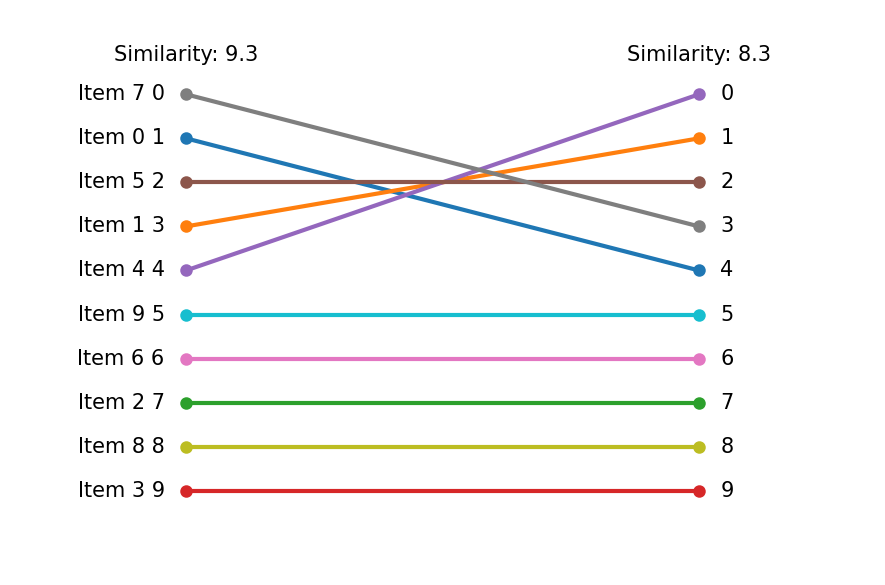

In [32]:
pre_string = "Similarity: {:.2g}".format(pre_similarity)
post_string = "Similarity: {:.2g}".format(post_similarity)
with slope() as slp:
    slp.plot(pre_order, post_order, items, (pre_string, post_string))

<!-- 最初の最適化結果と比較すると、下位部分は変数固定により変化はありません。
しかし、上位部分は類似度を考慮したことで、順番に変動が見られます。 -->

The left and right columns show the results without and with similarity term, respectively.
The lower positions remain unchanged due to fixing variables.
However, we can see the change in upper positions due to the similarity.

## References

* [Nishimura et al., 2019, "Item Listing Optimization for E-Commerce Websites Based on Diversity"](https://www.frontiersin.org/articles/10.3389/fcomp.2019.00002/full)  